In [2]:
from parse_crystfel_stream import parse_crystfel_stream

stream_file = "/home/bubl3932/files/MFM300_VIII/MFM300_VIII_spot9_20250408_1441/xgandalf_iterations_max_radius_0.0_step_1.0/MFM300V3S9_0.0_0.0.stream"

df_refl, df_cryst = parse_crystfel_stream(stream_file, debug=True)

Parsed 135278 reflection rows total.
Parsed 425 crystal rows (events).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppose you already have df_refl, df_cryst from parse_crystfel_stream

# Each row of df_cryst has columns like:
#  event, astar, bstar, cstar, a, b, c, alpha, beta, gamma
# where astar, bstar, cstar are each [vx, vy, vz].
# We'll expand these into individual columns for easier merging and computation.

def expand_vector_columns(df, colname):
    """
    df[colname] is a list/tuple of 3 floats [vx, vy, vz].
    We'll expand them into colname+'_x', colname+'_y', colname+'_z'
    """
    return pd.DataFrame(
        df[colname].tolist(), 
        index=df.index, 
        columns=[f"{colname}_x", f"{colname}_y", f"{colname}_z"]
    )

# Make copies so we don't overwrite the original
df_cryst_expanded = df_cryst.copy()

for vec in ["astar", "bstar", "cstar"]:
    if vec in df_cryst_expanded.columns:
        # Expand into separate columns
        expanded = expand_vector_columns(df_cryst_expanded, vec)
        # Add to df_cryst_expanded
        for c in expanded.columns:
            df_cryst_expanded[c] = expanded[c]
        # Drop the original vector column
        df_cryst_expanded.drop(columns=[vec], inplace=True, errors="ignore")

# Now df_cryst_expanded has columns:
#   ['event', 'a', 'b', 'c', 'alpha', 'beta', 'gamma',
#    'astar_x','astar_y','astar_z', 'bstar_x','bstar_y','bstar_z',
#    'cstar_x','cstar_y','cstar_z']

# Merge reflection data with crystal data on 'event'
df_merged = pd.merge(df_refl, df_cryst_expanded, on='event', how='left')

df_merged.head()


,event,h,k,l,I,sigma_I,peak,background,fs_px,ss_px,...,gamma,astar_x,astar_y,astar_z,bstar_x,bstar_y,bstar_z,cstar_x,cstar_y,cstar_z
0,113-1,-44,-37,9,7.18,24.20,10.0,0.32,948.1,1002.5,...,90.53556,-0.131464,-0.501433,0.386496,-0.38401,-0.280624,-0.48473,0.659271,-0.413683,-0.264143
1,113-1,-42,-38,14,-14.94,24.53,10.0,-0.06,1006.6,954.8,...,90.53556,-0.131464,-0.501433,0.386496,-0.38401,-0.280624,-0.48473,0.659271,-0.413683,-0.264143
2,113-1,-39,-35,12,-39.84,26.12,9.0,-0.29,957.4,928.6,...,90.53556,-0.131464,-0.501433,0.386496,-0.38401,-0.280624,-0.48473,0.659271,-0.413683,-0.264143
3,113-1,-39,-33,8,17.54,24.49,10.0,-0.42,899.1,947.3,...,90.53556,-0.131464,-0.501433,0.386496,-0.38401,-0.280624,-0.48473,0.659271,-0.413683,-0.264143
4,113-1,-39,-31,4,4.66,22.57,9.0,-0.03,840.8,965.9,...,90.53556,-0.131464,-0.501433,0.386496,-0.38401,-0.280624,-0.48473,0.659271,-0.413683,-0.264143


In [5]:
import matplotlib.pyplot as plt

def plot_intensity_histogram(df_merged, asu_idx, bins=50):
    """
    Plot a histogram of intensities for all reflections that map to the specified symmetry group.
    
    Parameters:
        df_merged (pd.DataFrame): The merged DataFrame that includes an "asu_index" column and an intensity "I" column.
        asu_idx (tuple): The symmetry group identifier (e.g., (h_asu, k_asu, l_asu)).
        bins (int): Number of bins for the histogram.
    """
    # Filter the DataFrame for rows that belong to the given symmetry group
    group = df_merged[df_merged["asu_index"] == asu_idx]
    
    if group.empty:
        print(f"No data found for symmetry group {asu_idx}")
        return

    # Extract the intensity values from the group
    intensities = group["I"].values

    # Create the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(intensities, bins=bins, color="skyblue", edgecolor="black")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.title(f"Intensity Histogram for Symmetry Group {asu_idx}")
    plt.tight_layout()
    plt.show()

# Example usage:
# Replace (3, 2, 1) with the desired asu_index from your DataFrame.
plot_intensity_histogram(df_merged, asu_idx=(-44, -37, 9), bins=50)

KeyError: 'asu_index'

In [6]:
grouped = df_merged.groupby(["h", "k", "l"])


In [7]:
# Group by the reflection indices and count the number of occurrences
common_refl = df_merged.groupby(["h", "k", "l"]).size().reset_index(name="count")

# Sort the results by count in descending order
common_refl.sort_values("count", ascending=False, inplace=True)

# Display the top 10 most common reflections
print(common_refl.head(10))


       h  k   l  count
40881  2  3   9     21
40682  2 -3  -9     18
34702 -2  3  -9     18
37736  0  0  -4     17
36152 -1  1  24     17
40840  2  2 -10     17
40811  2  1  -3     16
39320  1  1  -4     16
37640  0 -3  -3     16
39357  1  2  11     15


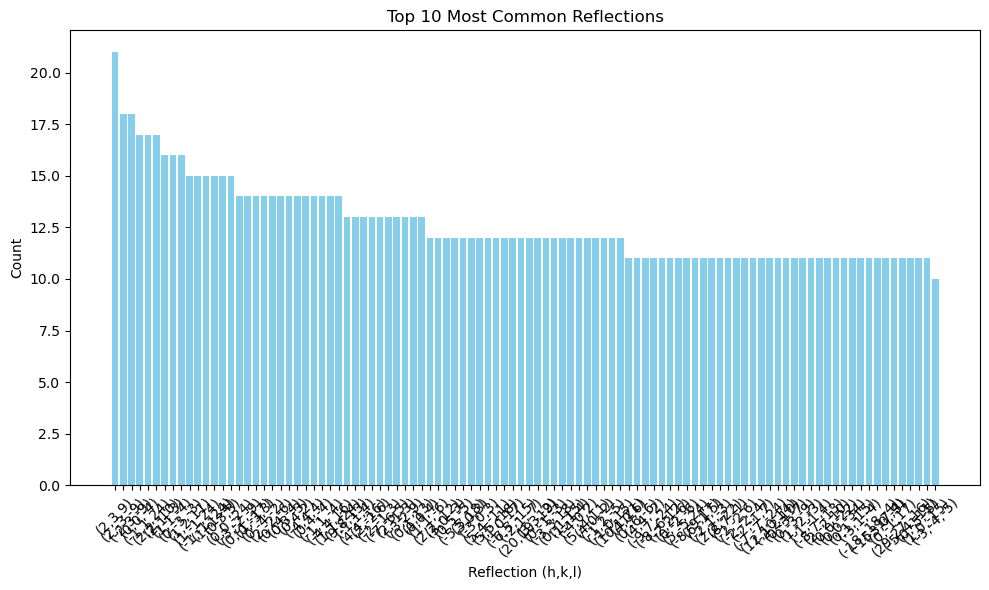

In [8]:
import matplotlib.pyplot as plt

# Create a new column with a string representation of the reflection for labeling
common_refl["reflection"] = common_refl.apply(lambda row: f"({row['h']},{row['k']},{row['l']})", axis=1)

# Plot the top 10 most common reflections
top_refs = common_refl.head(100)
plt.figure(figsize=(10, 6))
plt.bar(top_refs["reflection"], top_refs["count"], color="skyblue")
plt.xlabel("Reflection (h,k,l)")
plt.ylabel("Count")
plt.title("Top 10 Most Common Reflections")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Example: get group for reflection h=1, k=2, l=3
reflection_123 = grouped.get_group((6, -6, 0))

print(reflection_123)


          event  h  k  l        I  sigma_I   peak  background  fs_px  ss_px  \
84171    6763-1  6 -6  0  2198.50   117.54  472.0       11.36  483.6  418.1   
96828    7429-1  6 -6  0  2383.52   121.45  397.0       15.28  483.6  418.1   
118934  13676-1  6 -6  0   611.93    64.28  126.0       10.47  460.0  595.6   

        ...     gamma   astar_x   astar_y   astar_z   bstar_x   bstar_y  \
84171   ...  89.41428  0.235545 -0.521972 -0.309159  0.443290  0.389104   
96828   ...  89.94931  0.243286 -0.521904 -0.306943  0.450823  0.389122   
118934  ...  89.07241 -0.203906  0.430684  0.453718  0.235298 -0.393473   

         bstar_z   cstar_x   cstar_y   cstar_z  
84171  -0.305459  0.541463 -0.141991  0.587259  
96828  -0.303371  0.524200 -0.145475  0.583951  
118934  0.464347  0.735414  0.393299 -0.016050  

[3 rows x 26 columns]


In [10]:
# Compute the Qx, Qy, Qz columns vectorized:
df_merged["Qx"] = df_merged["h"] * df_merged["astar_x"] + \
                   df_merged["k"] * df_merged["bstar_x"] + \
                   df_merged["l"] * df_merged["cstar_x"]

df_merged["Qy"] = df_merged["h"] * df_merged["astar_y"] + \
                   df_merged["k"] * df_merged["bstar_y"] + \
                   df_merged["l"] * df_merged["cstar_y"]

df_merged["Qz"] = df_merged["h"] * df_merged["astar_z"] + \
                   df_merged["k"] * df_merged["bstar_z"] + \
                   df_merged["l"] * df_merged["cstar_z"]

# Compute the norm in a vectorized way:
df_merged["Q_norm"] = np.sqrt(df_merged["Qx"]**2 + df_merged["Qy"]**2 + df_merged["Qz"]**2) + 1e-30

# Normalize to get unit vectors:
df_merged["Qx_unit"] = df_merged["Qx"] / df_merged["Q_norm"]
df_merged["Qy_unit"] = df_merged["Qy"] / df_merged["Q_norm"]
df_merged["Qz_unit"] = df_merged["Qz"] / df_merged["Q_norm"]


In [12]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt

def plot_spherical_heatmap(df_merged, h, k, l, n_theta=36, n_phi=72):
    """
    Create a spherical heatmap of the reflection intensity for reflection (h, k, l).
    
    Steps:
      1) Extract all measured (x,y,z) directions on the unit sphere for (h,k,l).
      2) Convert each to spherical angles (theta, phi).
      3) Bin the angles -> compute average intensity in each bin.
      4) Plot a 3D sphere, coloring each bin's surface patch by avg intensity.
    
    Arguments:
        df_merged: Your merged DataFrame, which has columns:
                   'Qx_unit', 'Qy_unit', 'Qz_unit' (unit vectors) and 'I' (intensities).
        h, k, l:   Miller indices of the reflection you want to visualize.
        n_theta:   Number of bins in the polar/inclination direction (0 to pi).
        n_phi:     Number of bins in the azimuthal direction (0 to 2*pi).
    """
    # Subset for the chosen reflection
    group = df_merged[(df_merged["h"] == h) &
                      (df_merged["k"] == k) &
                      (df_merged["l"] == l)]
    if len(group) == 0:
        print(f"No data found for reflection ({h},{k},{l})")
        return

    # Extract unit-sphere coords and intensities
    x = group["Qx_unit"].values
    y = group["Qy_unit"].values
    z = group["Qz_unit"].values
    intensities = group["I"].values

    # Convert each (x,y,z) to spherical angles:
    #   phi   in [0, 2*pi],   phi=0 along +x, increases toward +y
    #   theta in [0,   pi ],  theta=0 at +z, increases down to -z
    phi = np.arctan2(y, x)            # range -π to +π
    phi[phi < 0] += 2*np.pi           # shift to [0, 2π)
    theta = np.arccos(z)             # range [0, π]

    # Create bin edges in theta and phi
    theta_bins = np.linspace(0, np.pi, n_theta+1)
    phi_bins = np.linspace(0, 2*np.pi, n_phi+1)

    # 2D histogram for "counts" in each (theta, phi) bin
    # 2D histogram for "sum of intensities" in each (theta, phi) bin
    counts, _, _ = np.histogram2d(theta, phi, bins=(theta_bins, phi_bins))
    sums, _, _ = np.histogram2d(theta, phi, bins=(theta_bins, phi_bins),
                                weights=intensities)

    # Average intensity per bin
    avg_intensity = sums / np.maximum(counts, 1)  # avoid divide-by-zero

    # For plotting, we build a mesh at the centers of these bins
    #   Phi  in shape (n_theta, n_phi)
    #   Theta in shape (n_theta, n_phi)
    theta_centers = 0.5 * (theta_bins[:-1] + theta_bins[1:])
    phi_centers   = 0.5 * (phi_bins[:-1]   + phi_bins[1:])
    Theta, Phi    = np.meshgrid(theta_centers, phi_centers, indexing='ij')

    # Convert back to Cartesian on the unit sphere
    X = np.sin(Theta) * np.cos(Phi)
    Y = np.sin(Theta) * np.sin(Phi)
    Z = np.cos(Theta)

    # avg_intensity is shape (n_theta, n_phi),
    # but our mesh is (n_theta, n_phi) => they match.
    # We'll normalize intensities so we can apply a colormap.
    # (If all intensities are identical, the colormap can appear uniform.)
    i_min, i_max = avg_intensity.min(), avg_intensity.max()
    # If i_max == i_min, everything is the same intensity.
    denom = i_max - i_min if (i_max > i_min) else 1e-30
    normed = (avg_intensity - i_min) / denom

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # We'll use plot_surface with facecolors mapped from normed intensities.
    # E.g., use "viridis" colormap; you can choose any built-in cmap you like.
    facecolors = plt.cm.viridis(normed)

    surf = ax.plot_surface(X, Y, Z, facecolors=facecolors,
                           rcount=n_theta, ccount=n_phi)

    # Add a colorbar. We create a ScalarMappable just for the color scale.
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    mappable.set_array(avg_intensity)
    cbar = plt.colorbar(mappable, ax=ax)
    cbar.set_label("Average Intensity")

    ax.set_title(f"Spherical Heatmap for Reflection ({h},{k},{l})")
    # Optionally, turn off axis lines:
    # ax.set_axis_off()
    plt.show()

# Example usage
plot_spherical_heatmap(df_merged, h=6, k=-6, l=0, n_theta=36, n_phi=72)


In [13]:
from cctbx import crystal, miller
from cctbx.array_family import flex

# Example placeholders (replace with your actual cell):
# unit_cell = (87.4, 87.4, 87.4, 90.0, 90.0, 90.0)
# space_group_symbol = "Fm-3m"  # or any other, e.g. "P212121"
unit_cell = (15.12, 15.12, 12.08, 90.0, 90.0, 90.0)
space_group_symbol = "I4(1)22"  # or any other, e.g. "P212121"

cryst_sym = crystal.symmetry(
    unit_cell=unit_cell,
    space_group_symbol=space_group_symbol
)

# all_indices is a list of (h,k,l) from your DataFrame
all_indices = list(zip(df_merged["h"], df_merged["k"], df_merged["l"]))

all_indices_flex = flex.miller_index(all_indices)
ms = miller.set(
    crystal_symmetry=cryst_sym,
    indices=all_indices_flex,
    anomalous_flag=False  # or True if relevant
)

ms_asu = ms.map_to_asu()
mapped_indices = list(ms_asu.indices())  # cctbx 'asu' index

# Attach these to df_merged
df_merged["asu_index"] = mapped_indices


In [14]:
grouped_asu = df_merged.groupby("asu_index")


In [15]:
# Count how many reflections fall in each symmetry group
counts = grouped_asu.size().reset_index(name="count")
counts.sort_values("count", ascending=False, inplace=True)
print(counts.head(10))


      asu_index  count
78    (2, 1, 3)    136
170   (3, 2, 9)    120
123   (3, 0, 3)    106
169   (3, 2, 7)    105
79    (2, 1, 5)     96
80    (2, 1, 7)     95
341   (5, 1, 2)     95
38    (1, 1, 4)     94
48   (1, 1, 24)     92
231   (4, 1, 1)     92


In [31]:
import matplotlib.pyplot as plt

def plot_intensity_histogram(df_merged, asu_idx, bins=50):
    """
    Plot a histogram of intensities for all reflections that map to the specified symmetry group.
    
    Parameters:
        df_merged (pd.DataFrame): The merged DataFrame that includes an "asu_index" column and an intensity "I" column.
        asu_idx (tuple): The symmetry group identifier (e.g., (h_asu, k_asu, l_asu)).
        bins (int): Number of bins for the histogram.
    """
    # Filter the DataFrame for rows that belong to the given symmetry group
    group = df_merged[df_merged["asu_index"] == asu_idx]
    
    if group.empty:
        print(f"No data found for symmetry group {asu_idx}")
        return

    # Extract the intensity values from the group
    intensities = group["I"].values

    # Create the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(intensities, bins=bins, color="skyblue", edgecolor="black")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.title(f"Intensity Histogram for Symmetry Group {asu_idx}")
    plt.tight_layout()
    plt.show()

# Example usage:
# Replace (3, 2, 1) with the desired asu_index from your DataFrame.
plot_intensity_histogram(df_merged, asu_idx=(2, 1, 5), bins=200)


In [54]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spherical_heatmap_asu(df_merged, asu_idx, n_theta=36, n_phi=72):
    """
    Create a spherical heatmap of the reflection intensity for ALL reflections
    that map to a particular ASU index (h_asu, k_asu, l_asu). This lumps together
    all symmetry-equivalent (h,k,l).
    
    Steps:
      1) Extract all measured (x,y,z) directions on the unit sphere for that asu_idx.
      2) Convert each to spherical angles (theta, phi).
      3) Bin the angles -> compute average intensity in each bin.
      4) Plot a 3D sphere, coloring each bin's surface patch by avg intensity.
    """
    # Select the subset of data for this group
    group = df_merged[df_merged["asu_index"] == asu_idx]
    
    if len(group) == 0:
        print(f"No data found for asu_index {asu_idx}")
        return

    # Extract unit-sphere coords and intensities
    x = group["Qx_unit"].values
    y = group["Qy_unit"].values
    z = group["Qz_unit"].values
    intensities = group["I"].values

    # Convert (x,y,z) to spherical angles
    phi = np.arctan2(y, x)  # range -π to +π
    phi[phi < 0] += 2*np.pi  # shift to [0, 2π)
    theta = np.arccos(z)     # range [0, π]

    # Bin edges
    theta_bins = np.linspace(0, np.pi, n_theta + 1)
    phi_bins   = np.linspace(0, 2*np.pi, n_phi + 1)

    # 2D histograms: counts and sums
    counts, _, _ = np.histogram2d(theta, phi, bins=(theta_bins, phi_bins))
    sums,   _, _ = np.histogram2d(theta, phi, bins=(theta_bins, phi_bins),
                                  weights=intensities)

    avg_intensity = sums / np.maximum(counts, 1)

    # Build grid for plotting
    theta_centers = 0.5*(theta_bins[:-1] + theta_bins[1:])
    phi_centers   = 0.5*(phi_bins[:-1]   + phi_bins[1:])
    Theta, Phi    = np.meshgrid(theta_centers, phi_centers, indexing='ij')

    # Map spherical -> Cartesian
    X = np.sin(Theta) * np.cos(Phi)
    Y = np.sin(Theta) * np.sin(Phi)
    Z = np.cos(Theta)

    # Normalize intensities for colormap
    i_min, i_max = avg_intensity.min(), avg_intensity.max()
    denom = (i_max - i_min) if (i_max > i_min) else 1e-30
    normed = (avg_intensity - i_min) / denom

    # 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    facecolors = plt.cm.viridis(normed)
    surf = ax.plot_surface(X, Y, Z, facecolors=facecolors,
                           rcount=n_theta, ccount=n_phi)

    # Colorbar
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    mappable.set_array(avg_intensity)
    cbar = plt.colorbar(mappable, ax=ax)
    cbar.set_label("Average Intensity")

    ax.set_title(f"Spherical Heatmap for ASU index {asu_idx}")
    plt.show()


In [60]:
plot_spherical_heatmap_asu(df_merged, asu_idx=(0,1,1), n_theta=36, n_phi=72)
